# Urban Sound Classification

The aim of this project is to build up a classification model to distinguish different sound in urban context, which serves as a basis on further study on urban environment. The urban sound dataset is URBANSOUND8K from the Center for Urban Science and Progress (CUSP) at NYU (https://urbansounddataset.weebly.com/urbansound8k.html). 

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. 

In order to better understand involved machine learning algorithms(Linear Multiclass SVM, Kernelized Multiclass SVM), all the methods and algorithms are writen by ***numpy*** instead of ***sklearn***. 

## Load modules

In [217]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
%matplotlib inline

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

## 1. Multiclass linear SVM

First, I will try a multiclass linear SVM to conduct the classification.

Mel-Frequency Cepstral Coefficients (MFCC) is used to extract features from the audio records. It can be calculated by the module ***librosa***.

Use the first 25 MFCC's summary statistics (minimum, maximum, me- dian, mean, variance, skewness, kurtosis and the mean and variance of the first and second derivatives) to form the inputs X.

In [227]:
def mel_feacture_generator(y, sr, n_mfcc = 25):
    '''
    Calculate Mel-Frequency Cepstral Coefficients (MFCC) for certian audio record.
    Generate summary statistics and finally get a feature vector of 275 dimensions.
    '''
    
    # Extract the top n_mfcc Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Generate summary statistics for the 25 coefficents
    ## minimum
    mfcc_min = mfcc.min(axis = 1)
    ## maximum
    mfcc_max = mfcc.max(axis = 1)
    ## median
    mfcc_med = np.median(mfcc, axis = 1)
    ## mean
    mfcc_mean = mfcc.mean(axis = 1)
    ## variance
    mfcc_var = mfcc.var(axis = 1)
    ## skewness
    mfcc_skew = stats.skew(mfcc, axis = 1)
    ## kurtosis
    mfcc_kur = stats.kurtosis(mfcc, axis = 1)
    ## mean of first derivatives
    delta_mfcc  = librosa.feature.delta(mfcc)
    mfcc_d1_mean = delta_mfcc.mean(axis = 1)
    ## variance of first derivatives
    mfcc_d1_var = delta_mfcc.var(axis = 1)
    ## mean of second derivatives
    delta2_mfcc  = librosa.feature.delta(mfcc, order=2)
    mfcc_d2_mean = delta2_mfcc.mean(axis = 1)
    ## variance of second derivatives
    mfcc_d2_var = delta2_mfcc.var(axis = 1)

    # stack features together
    M = np.concatenate([mfcc_min, mfcc_max, mfcc_med, mfcc_mean, mfcc_var, mfcc_skew, mfcc_kur, mfcc_d1_mean,
                        mfcc_d1_var, mfcc_d2_mean, mfcc_d2_var])
    
    return M

In [267]:
'''
    Load audio records from folders without foldi. Use foldi as validation set.
    Would take a long time for running this function.
'''
def load_witout_i(i):
    data_path = "/Users/chenwangyang/NYU Machine Learning/UrbanSound8K/audio"
    filelist = os.listdir(data_path)
    filelist.remove('.DS_Store')
    filelist.remove('fold{}'.format(i))
    filelist.sort()
    class_list = []
    y_list = []
    sr_list = []
    
    for fold in filelist:
        fold_path = os.path.join(data_path,fold)
        fold_filelist = os.listdir(fold_path)
        fold_filelist.sort()  
        for audio in fold_filelist:
            try:
                if audio == '.DS_Store':
                    continue
                else:
                    class_index = audio.find('-')+1
                    class_list.append(int(audio[class_index]))
                    audio_path = os.path.join(fold_path,audio)
                    y, sr = librosa.load(audio_path)
                    y_list.append(y)
                    sr_list.append(sr)
            except:
                continue
    return y_list, sr_list, class_list

In [268]:
# Load audio records from a single folder
def load_i(i):
    data_path = "/Users/chenwangyang/NYU Machine Learning/UrbanSound8K/audio/fold{}".format(i)
    filelist = os.listdir(data_path)
    class_list = []
    y_list = []
    sr_list = []
    for audio in filelist:
        try:
            if audio == '.DS_Store':
                continue
            else:
                class_index = audio.find('-')+1
                class_list.append(int(audio[class_index]))
                audio_path = os.path.join(data_path,audio)
                y, sr = librosa.load(audio_path)
                y_list.append(y)
                sr_list.append(sr)
        except:
            continue
    return y_list, sr_list, class_list

Test the algorithm with setting fold10 as validation set. Load data.

In [324]:
# Generate training set X_train and y_train
y_list, sr_list, class_list = load_witout_i(10)
X_train = np.zeros((len(y_list), 275))
for i, (y, sr) in enumerate(zip(y_list, sr_list)):
    try:
        X_train[i] = mel_feacture_generator(y, sr, n_mfcc = 25)
    except:
        continue
        
y_train = np.array(class_list).reshape(-1,1)

In [325]:
# Generate validation set X_test and y_test
y_list, sr_list, class_list = load_i(10)
X_test = np.zeros((len(y_list), 275))
for i, (y, sr) in enumerate(zip(y_list, sr_list)):
    try:
        X_test[i] = mel_feacture_generator(y, sr, n_mfcc = 25)
    except:
        continue

y_test = np.array(class_list).reshape(-1,1)

In [326]:
# Multiclass SVM classifier 
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    #your code goes here, and replaces following return
    num_outFeatures = num_classes*num_inFeatures
    
    if num_samples == 1:
        feature_map = np.zeros(num_outFeatures)
        feature_map[int(y*num_inFeatures):int((y+1)*num_inFeatures)] = X
        return feature_map
    else:
        feature_mat = np.zeros((num_samples,num_outFeatures))
        for i, xi in enumerate(X):
            feature_mat[i][y[i]*num_inFeatures:(y[i]+1)*num_inFeatures] = xi
        return feature_mat

def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    w = np.zeros(num_outFeatures)
    #your code goes here and replaces following return statement
    t=1
    while(t<=T):
        random_indx = np.random.choice(2000)
        w -= eta * subgd(X[random_indx], y[random_indx], w)
        t += 1
    return w

In [327]:
# Linear Multiclass SVM
class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, lam=1.0, num_classes=4, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        #Your code goes here and replaces the following return statement
        temp_list = []
        for yi in range(self.num_classes):
            temp_list.append(self.Delta(y,yi)-np.dot(w, self.Psi(x,y)-self.Psi(x,yi)))
        y_hat = np.argmax(temp_list)
        g = 2*self.lam*w + self.Psi(x,y_hat)-self.Psi(x,y)
        return g
    
    def fit(self,X,y,eta=0.01,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        num_outFeatures = X.shape[1] * self.num_classes
        self.coef_ = sgd(X,y,num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        num_samples = X.shape[0]
        #Your code goes here and replaces following return statement
        score_matrix = np.zeros((num_samples, self.num_classes))
        for i, x_i in enumerate(X):
            score_matrix[i,:] = [np.dot(self.coef_, self.Psi(x_i,yi)) for yi in range(self.num_classes)]
        return score_matrix
    
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        #Your code goes here and replaces following return statement
        score_matrix = self.decision_function(X)
        predicts = np.argmax(score_matrix, axis = 1)
        return predicts

In [328]:
#the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
train_est = MulticlassSVM(lam=1, num_classes = 10)
train_est.fit(X_train, y_train)

from sklearn import metrics
print("\nTrain set confusion matrix:\n")
print(metrics.confusion_matrix(y_train, train_est.predict(X_train)))


Train set confusion matrix:

[[482   0 198   0   0  47 157   0  16   0]
 [ 40   0 115   0   0   5 204   0  32   0]
 [ 31   0 358   0   0   0 473   0  38   0]
 [ 32   0 121   2   0   0 730   0  15   0]
 [ 51   0 139   1   0  17 582   2 108   0]
 [424   0 231   0   0  37 193   0  22   0]
 [  2   0   2   0   0   0 338   0   0   0]
 [ 98   0 261   1   0  48 478   0  18   0]
 [120   0 146   0   0  31 211   0 338   0]
 [ 16   0 322   0   0   6 499   0  57   0]]


In [329]:
def cal_accuracy(y_real, y_predict):
    '''
    Calculating accuracy rate of the model
    y_real: 1d-array, real classes of n entry x
    y_predict: 1d-array, predicted classes of n entry x
    
    '''
    
    corrects = ((y_real==).sum()
    return corrects/y_real.shape[0]

In [368]:
# Accuracy rate of the linear multiclass SVM
print('The accuary rate of training set is:')
print(cal_accuracy(y_train.reshape(-1), train_est.predict(X_train)).round(3))

The accuary rate of training set is:
0.197


## 2. Kernelized multiclass SVM

It seems that linear multiclass SVM performs pretty bad in this audio classification task. Next we will try kernelized multiclass SVM to build the model and see whether situation goes better-off.

In [ ]:
# one vs all kernel multiclass SVM
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        for i in range(len(self.estimators)):
            y_list = np.zeros(len(y))
            y_list = np.where(y==i, 1, 0)
            self.estimators[i].fit(X,y_list)
        self.fitted = True
        return self
        
    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Replace the following return statement with your code
        ret_row = X.shape[0]
        ret_col = self.n_classes
        ret_mat = np.zeros((ret_row, ret_col))
        for i in range(self.n_classes):
            ret_mat[:,i] = self.estimators[i].decision_function(X)
        return ret_mat
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Replace the following return statement with your code
        all_predicts = self.decision_function(X)
        predict = np.argmax(all_predicts, axis = 1)
        return predict

In [299]:
# Kernel function generators
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    #TODO
    rbf_kernel = np.zeros(shape = (X1.shape[0],X2.shape[0]))
    norm = scipy.spatial.distance.cdist(X1,X2,'sqeuclidean')
    rbf_kernel = np.exp(-norm/(2*sigma**2))
    return rbf_kernel
    
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    #TODO
    return (offset+linear_kernel(X1,X2))**degree


In [301]:
# A class for convenient prediction
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(W,X) - a function return the cross-kernel matrix between rows of W and rows of X for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        cross_kernel_matrix = self.kernel(X, self.prototype_points)
        return np.dot(cross_kernel_matrix,self.weights)

In [302]:
'''
train_soft_svm takes the numpy arrays containing the measurements of x in R^{2 x d} and y in R^d, 
the kernel, the maximum number of SGD steps T and the regularization parameter Lambda.
It returns the corresponding Kernel_Machine.
'''
def train_soft_svm(X, y, kernel, T, Lambda):
    
    # sgd_for_soft_svm implements the above-mentioned method from SSBD.
    # It takes the numpy arrays containing the measurements y in {-1,+1},
    # the kernel K in R^{d x d} the maximum number of steps T and 
    # the regularization parameter lambda. It returns the coefficients alpha_bar
    # of the solution w_bar represented as a linear combination  
    def sgd_for_soft_svm (y, K, T, Lambda): 
        sample_size = len(y)
        beta=[] 
        beta.append(np.zeros(sample_size))
        alpha = []
    
        for t in range(T):
            alpha_temp= (beta[t] / (Lambda*(t+1) ))
            i = np.random.randint(sample_size)
            beta_temp = beta[t]
            temp=0
            for j in range (sample_size): 
                temp = temp+ alpha_temp[j]* K[j,i]
            if ((y[i]*temp)<1):
                beta_temp[i]= beta_temp[i]+y[i]         
            beta.append(beta_temp)
            alpha.append(alpha_temp)
        alpha_bar = 1/T* np.sum(alpha, axis=0)                  
        return alpha_bar
    
    K = kernel(X,X)
    alpha= sgd_for_soft_svm (y, K, T, Lambda)
    return Kernel_Machine(kernel, X, alpha)

In [318]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

# Kernel soft SVM class
class KernelSoftSVM(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="linear", sigma=1, degree=2, offset=1, T = 1000, l2reg=0.2):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 
        self.T = T

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_soft_svm(X, y, self.k, self.T, self.l2reg)

        return self

    def decision_function(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))
        
    def score(self, X, y=None):
        # get the average square error
        return((self.predict(X)-y).mean())

### 1) Try the kernel multiclass support vector classfier provided by *sklearn* module

In [339]:
from sklearn import svm
svm_estimator = svm.SVC(kernel = 'rbf', C=10)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=10)
clf_onevsall.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to

OneVsAllClassifier(estimator=None, n_classes=10)

In [361]:
svm_estimator.fit(X_train,y_train)
y_train_predict = svm_estimator.predict(X_train)
print("\nsklearn SVM: Train set confusion matrix:\n")
print(metrics.confusion_matrix(y_train, y_train_predict))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



sklearn SVM: Train set confusion matrix:

[[900   0   0   0   0   0   0   0   0   0]
 [  0 396   0   0   0   0   0   0   0   0]
 [  0   0 900   0   0   0   0   0   0   0]
 [  0   3   0 897   0   0   0   0   0   0]
 [  0   0   0   0 900   0   0   0   0   0]
 [  0   0   0   0   0 907   0   0   0   0]
 [  0   2   0   0   0   0 340   0   0   0]
 [  0   0   0   0   0   0   0 904   0   0]
 [  0   0   0   0   0   0   0   0 846   0]
 [  0   0   0   0   0   0   0   0   0 900]]


In [371]:
# Accuracy rate of sklearn multiclass SVM in traing set
print('Accuracy rate of the sklearn multiclass SVM in traing set:')
print(cal_accuracy(y_train.reshape(-1), y_train_predict).round(3))

Accuracy rate of the sklearn multiclass SVM in traing set:
0.999


In [369]:
y_test_predict = svm_estimator.predict(X_test)
print("\nsklearn SVM: Validation set confusion matrix:\n")
print(metrics.confusion_matrix(y_test, y_test_predict))


sklearn SVM: Validation set confusion matrix:

[[ 29   0  71   0   0   0   0   0   0   0]
 [  0   0  33   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0  93   0   0   0   0   0   0   0]
 [  0   0  32   0   0   0   0   0   0   0]
 [  0   0  96   0   0   0   0   0   0   0]
 [  0   0  83   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]]


In [372]:
# Accuracy rate of sklearn multiclass SVM in traing set
print('Accuracy rate of the sklearn multiclass SVM in traing set:')
print(cal_accuracy(y_test.reshape(-1), y_test_predict).round(3))

Accuracy rate of the sklearn multiclass SVM in traing set:
0.154


It turns out that sklearn SVM performs pretty good in training set with a nearly 100% percent accuracy. However, the performance on the validation set becomes pretty bad. It causes obvious overfitting. 

### 2) Try the kernelized multiclass SVM writen by myself

In [374]:
svm_estimator = KernelSoftSVM(kernel = 'RBF',sigma=1, T = 2000, l2reg=1)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=10)
clf_onevsall.fit(X_train,y_train)

OneVsAllClassifier(estimator=None, n_classes=10)

In [375]:
y_train_predict2 = clf_onevsall.predict(X_train)
print("\nTrain set confusion matrix:\n")
print(metrics.confusion_matrix(y_train, y_train_predict2))


Train set confusion matrix:

[[900   0   0   0   0   0   0   0   0   0]
 [281 115   0   0   0   0   0   0   0   0]
 [693   0 207   0   0   0   0   0   0   0]
 [700   3   0 197   0   0   0   0   0   0]
 [679   0   0   0 219   0   0   2   0   0]
 [443   0   0   0   0 464   0   0   0   0]
 [261   2   0   0   0   0  79   0   0   0]
 [662   0   0   0   5   0   0 236   0   1]
 [648   0   0   0   0   0   0   0 198   0]
 [707   0   0   0   0   0   0   0   0 193]]


In [378]:
# Accuracy rate of sklearn multiclass SVM in traing set
print('Accuracy rate of the my kernel multiclass SVM in traing set:')
print(cal_accuracy(y_train.reshape(-1), y_train_preidict2).round(3))

Accuracy rate of the my kernel multiclass SVM in traing set:
0.356


### 3) Parameter adjustment

Due to the long running time for each adjustment, I only tried very limited range of parameter adjustment. 

In [386]:
# Find the best sigma
y_train_predict_list = []
y_test_predict_list = []
for sigma in range(-1,4):
    svm_estimatori = KernelSoftSVM(kernel = 'RBF',sigma=10**sigma, T = 2000, l2reg=1)
    clf_onevsalli = OneVsAllClassifier(svm_estimatori, n_classes=10)
    clf_onevsalli.fit(X_train,y_train)
    y_train_predicti = clf_onevsalli.predict(X_train)
    y_test_predicti = clf_onevsalli.predict(X_test)
    y_train_predict_list.append(y_train_predicti)
    y_test_predict_list.append(y_test_predicti)
    print('Accuracy rate in training set(sigma = {}):'.format(10**sigma))
    print(cal_accuracy(y_train.reshape(-1), y_train_predicti).round(3))
    print('Accuracy rate in validation set(sigma = {}):'.format(10**sigma))
    print(cal_accuracy(y_test.reshape(-1), y_test_predicti).round(3))
    print('--------------------------------------------------')

Accuracy rate in training set(sigma = 0.1):
0.312
Accuracy rate in validation set(sigma = 0.1):
0.119
--------------------------------------------------
Accuracy rate in training set(sigma = 1):
0.362
Accuracy rate in validation set(sigma = 1):
0.119
--------------------------------------------------
Accuracy rate in training set(sigma = 10):
0.645
Accuracy rate in validation set(sigma = 10):
0.281
--------------------------------------------------
Accuracy rate in training set(sigma = 100):
0.608
Accuracy rate in validation set(sigma = 100):
0.4
--------------------------------------------------
Accuracy rate in training set(sigma = 1000):
0.249
Accuracy rate in validation set(sigma = 1000):
0.27
--------------------------------------------------


In [393]:
# Find the best l2reg
y_train_predict_list_l = []
y_test_predict_list_l = []
for l2reg in [0.5,1,5,10,20]:
    svm_estimatorj = KernelSoftSVM(kernel = 'RBF',sigma=100, T = 2000, l2reg=l2reg)
    clf_onevsallj = OneVsAllClassifier(svm_estimatorj, n_classes=10)
    clf_onevsallj.fit(X_train,y_train)
    y_train_predictj = clf_onevsallj.predict(X_train)
    y_test_predictj = clf_onevsallj.predict(X_test)
    y_train_predict_list_l.append(y_train_predictj)
    y_test_predict_list_l.append(y_test_predictj)
    print('Accuracy rate in training set(l2reg = {}):'.format(l2reg))
    print(cal_accuracy(y_train.reshape(-1), y_train_predictj).round(3))
    print('Accuracy rate in validation set(l2reg = {}):'.format(l2reg))
    print(cal_accuracy(y_test.reshape(-1), y_test_predictj).round(3))
    print('--------------------------------------------------')

Accuracy rate in training set(l2reg = 0.5):
0.589
Accuracy rate in validation set(l2reg = 0.5):
0.436
--------------------------------------------------
Accuracy rate in training set(l2reg = 1):
0.605
Accuracy rate in validation set(l2reg = 1):
0.41
--------------------------------------------------
Accuracy rate in training set(l2reg = 5):
0.616
Accuracy rate in validation set(l2reg = 5):
0.399
--------------------------------------------------
Accuracy rate in training set(l2reg = 10):
0.607
Accuracy rate in validation set(l2reg = 10):
0.461
--------------------------------------------------
Accuracy rate in training set(l2reg = 20):
0.603
Accuracy rate in validation set(l2reg = 20):
0.416
--------------------------------------------------


In this case, we will choose the set of parameters with the highest accuarcy rate in test set.

Because both the single kernel SVM and the multiclass kernel SVM use Stochastic Gradient Decent (SGD), the number of iteration do relate to the final result. Finally let's try whether increasing the number of iteration would help with getting a better result.

In [395]:
svm_estimatork = KernelSoftSVM(kernel = 'RBF',sigma=100, T = 5000, l2reg=10)
clf_onevsallk = OneVsAllClassifier(svm_estimatork, n_classes=10)
clf_onevsallk.fit(X_train,y_train)
y_train_predictk = clf_onevsallk.predict(X_train)
y_test_predictk = clf_onevsallk.predict(X_test)
print('Accuracy rate in training set(More iteration):')
print(cal_accuracy(y_train.reshape(-1), y_train_predictk).round(3))
print('Accuracy rate in validation set(More iteration):')
print(cal_accuracy(y_test.reshape(-1), y_test_predictk).round(3))

Accuracy rate in training set(More iteration):
0.681
Accuracy rate in validation set(More iteration):
0.467


Both accuarcte rates of train and validation set are improved to some extent. Because our main goal is to find the possible way to build the urban sound classification model, our parameter tuning ends here though there is still a large space for us to adjust. We regard 'sigma = 100' and 'l2reg = 10' as our final parameters. 

### 4) Present final outcome

I will present the final outcome in the next section.

In [403]:
# Confusion matrix for training set
print("\nTraining set confusion matrix:\n")
print(metrics.confusion_matrix(y_train, y_train_predictk))


Training set confusion matrix:

[[602   2   6   2   5 174   0  65   2  42]
 [ 26  95  14   7  28  40  10 106   2  68]
 [ 24   2 554  32  18  48   5  27  12 178]
 [ 24   3  77 624  20  35  35  10   7  65]
 [ 52   5   4  10 506  32  15 236   1  39]
 [ 83   2   2   2   3 656   2 106   1  50]
 [  1   0   4  18  21   2 287   3   0   6]
 [ 56   2   2   2  25  17   2 781   0  17]
 [ 29   2  29  10   2  79   2  42 581  70]
 [ 12   1  54   4  12  39   2  75  12 689]]


In [400]:
# Calculate accurate rate for each class
def accuracy_for_classes(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    num_each_class = np.sum(confusion_matrix, axis = 1)
    correct_each_class = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        correct_each_class[i] = confusion_matrix[i,i]
    accuracy_each_class = correct_each_class/num_each_class
    return accuracy_each_class       

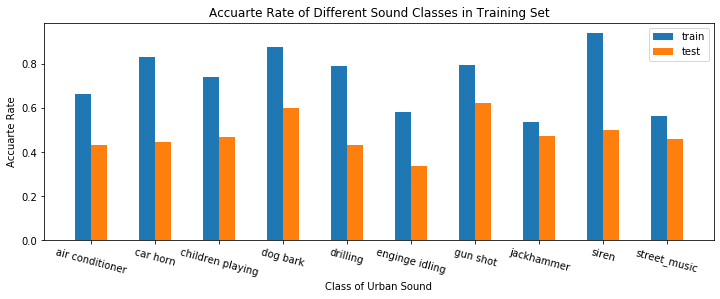

In [437]:
# present accuarte rate of different sound classes in training set
accuracy_each_class1 = accuracy_for_classes(metrics.confusion_matrix(y_train, y_train_predictk))
accuracy_each_class2 = accuracy_for_classes(metrics.confusion_matrix(y_test, y_test_predictk))
classes = ['air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling',
         'enginge idling', 'gun shot', 'jackhammer', 'siren', 'street_music']

fig = plt.figure(figsize=(12,4))
plt.bar(range(10), accuracy_each_class1, width=1/4, tick_label = classes, label = "train")
plt.bar(np.arange(10)+1/4, accuracy_each_class2, width=1/4, label = "test")
plt.xticks(np.arange(10)+1/8,rotation=-15)
plt.title("Accuarte Rate of Different Sound Classes in Training Set")
plt.xlabel("Class of Urban Sound")
plt.ylabel("Accuarte Rate")
plt.legend(loc='best')
plt.show()

According to the results, we can find that sounds which is short and sharp like dog bark and gun shot are relatively easier to discriminate, compared with more gentle and persistent sounds.

The final outcome shows that there is a clear gap between the accuarcy of train set and test set. It is possible to train the model to fit train set perfectly, accualy I have done it by sklearn SVM. But it would cause extreme overfitting and is unacceptable. Together with the reason that I want to test my understanding on the theories and algorithoms, I write the kernelized multiclass SVM from scratch. 

Due to my limited computer performance, I just do little parameter adjustment. In the future, if possible, we can use **SearchGrid** function to help with seeking the best parameter combinations. Also, as suggested by the data source, we should do the same training ten times, while in each time we set a different folder of data as validation set. Then we calculate the average accuracy to evaluate our model. Definately, there are still many works that could be done with this project. Will update this notebook in the future!